In [11]:
from frozen_lake import FrozenLakeEnv
import numpy as np
import sys

In [12]:
env = FrozenLakeEnv(map_name ="4x4", is_slippery=False)

# Access the number of states:
nS = env.observation_space
print("State space of the Env: ", nS)
# or you could even use 
nS = env.nS
print("State space of the Env by accessing env.nS: ", nS)

# Action space of the agent:
nA = env.nA
print("Action space of the Env: ", nA)

State space of the Env:  16
State space of the Env by accessing env.nS:  16
Action space of the Env:  4


In [13]:
"""
For policy iteration, you would need to access
State(s), Action(a), Next State(ns), Reward(r), episode ended? (is_done) tuples.

Note that in this environment, the orientation of the agent does not matter.
No matter what direction the agent is facing, if a left action is performed, 
the agent moves to the left of the current state.
"""
# For actions, this is the corresponding dictionary:
action_names = {0:'L', 1:'D', 2:"R", 3:"U"}
"""
Here, 
'L' means left
'D' means down
'R' means right
'U' means up

You can access these tuples by simply env.P[s][a],
where 's' is state, and 'a' is action. For example, let's say we are at state '4',
and we take an action '1' or "Down". The next state (ns) would be 8, the episode would not have ended (is_done), 
the reward (r) is 0 and the transition probabilty (prob) is 1 because this is a deterministic setting.
"""

prob, ns, r, is_done = env.P[4][1][0]
print("Transition Probabilty: ", prob)
print("Next State: ", ns)
print("Reward: ", r)
print("Episode ended? : ", is_done)
# Note that we need to add a [0] after env.P[s][a] because it returns a list containing the tuple
env.render()

Transition Probabilty:  1.0
Next State:  8
Reward:  0.0
Episode ended? :  False

SFFF
FHFH
FFFH
HFFG


In [14]:
def print_policy(policy, action_names, states):
    """Print the policy in human-readable format.
    If you've implemented this correctly, the output (for 4x4 map) should be:
    
    D R D L 
    D L D L 
    R D D L 
    L R R L 
    
    Parameters
    ----------
    policy: np.ndarray
        Array of state to action number mappings
    action_names: dict
        Mapping of action numbers to characters representing the action.
    num_states: int
        Number of states in the FrozenLakeEnvironment (16 or 64 for 4x4 or 8x8 maps respectively)      
    """
    i=0
    if states == 16:
        for i in range(4):
            index = 4*(i)
            print(action_names[policy[index]],' ',action_names[policy[index+1]],' ',action_names[policy[index+2]],' ',action_names[policy[index+3]])
    elif states == 64:
        for i in range(8):
            row = 8*i
            print(action_names[policy[row]],' ',action_names[policy[row+1]],' ',action_names[policy[row+2]],' ',action_names[policy[row+3]],' ',action_names[policy[row+4]],' ',action_names[policy[row+5]],' '
                 ,action_names[policy[row+6]],' ', action_names[policy[row+7]])
    
    

In [15]:
def evaluate_policy_sync(env, gamma, policy, max_iterations=int(1e3), tol=1e-3):
    """Performs policy evaluation.
    
    Evaluates the value of a given policy.

    Parameters
    ----------
    env: Frozen Lake Environment
      The environment to compute value iteration for.
    gamma: float
      Discount factor, must be in range [0, 1)
    policy: np.array
      The policy to evaluate. Maps states to actions.
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.

    Returns
    -------
    np.ndarray, int
      The value for the given policy and the number of iterations till
      the value function converged.
    """
    value_function = np.zeros(env.nS)
    val_iter = 0
    delta = np.zeros(env.nS)

    while (True):
        ok = 0
        val_iter+=1
        for i in range(env.nS):
            v = value_function[i]
            vs = 0
            prob, ns, r, is_done = env.P[i][policy[i]][0]
            vs += prob*(r+gamma*value_function[ns])                 # discount factor 0.9
            value_function[i] = vs
            if delta[i] < abs(v-vs):
                delta[i] = abs(v-vs)
            if delta[i] < tol:
                ok+=1
        if ok == env.nS:
            break
        if val_iter > max_iterations:
            break
         
    return value_function, val_iter

In [16]:
def improve_policy(env, gamma, value_func, policy):
    """Performs policy improvement.
    
    Given a policy and value function, improves the policy.

    Parameters
    ----------
    env: Frozen Lake Environment
      The environment to compute value iteration for.
    gamma: float
      Discount factor, must be in range [0, 1)
    value_func: np.ndarray
      Value function for the given policy.
    policy: dict or np.array
      The policy to improve. Maps states to actions.

    Returns
    -------
    bool, np.ndarray
      Returns true if policy stable. Also returns the new policy.
    """
    stable = True
    new_policy=[]
    for i in range(env.nS):
        oldpolicy = policy[i]
        vs = []
        for j in range(env.nA):
            prob, ns, r, is_done = env.P[i][j][0]
            vs.append(prob*(r+gamma*value_func[ns])) 
        action = vs.index(max(vs))
        new_policy.append(action)
        if action != oldpolicy:
            stable = False
    return stable, new_policy

In [17]:
def policy_iteration_sync(env, gamma, max_iterations=int(1e3), tol=1e-3):
    """Runs policy iteration.

    See page 85 of the Sutton & Barto Second Edition book.

    You should use the improve_policy() and evaluate_policy_sync() methods to
    implement this method.
    
    If you've implemented this correctly, it should take much less than 1 second.
    
    Parameters
    ----------
    env: Frozen Lake Environment
      The environment to compute value iteration for.
    gamma: float
      Discount factor, must be in range [0, 1)
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.

    Returns
    -------
    (np.ndarray, np.ndarray, int, int)
       Returns optimal policy, value function, number of policy
       improvement iterations, and number of value iterations.
    """
    policy = np.zeros(env.nS, dtype='int')
    value_func = np.zeros(env.nS)
    
    num_pol_iter = 0
    num_val_iter = 0
    stable = False
    while (not stable):
        value_function, num_val_iter = evaluate_policy_sync(env, gamma, policy, max_iterations=int(1e3), tol=1e-3)
        stable, new_policy = improve_policy(env, gamma, value_function, policy)
        policy = new_policy
        num_pol_iter +=1
        if max_iterations <= num_pol_iter:
            break;
    
    return policy, value_function, num_pol_iter, num_val_iter

In [18]:
policy, value_func, num_pol_iter, num_val_iter = policy_iteration_sync(env,0.9, max_iterations=int(1e3), tol=1e-3)
print('Policy:', policy)
print('Value function', value_func)
print('Number of policy iteration:', num_pol_iter)
print('Number of value iteration',num_val_iter)

Policy: [1, 2, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 0, 2, 2, 0]
Value function [0.59049 0.6561  0.729   0.6561  0.6561  0.      0.81    0.      0.729
 0.81    0.9     0.      0.      0.9     1.      0.     ]
Number of policy iteration: 7
Number of value iteration 1001


Text(0.5,1,'The value function for each state wrp to policy iteration')

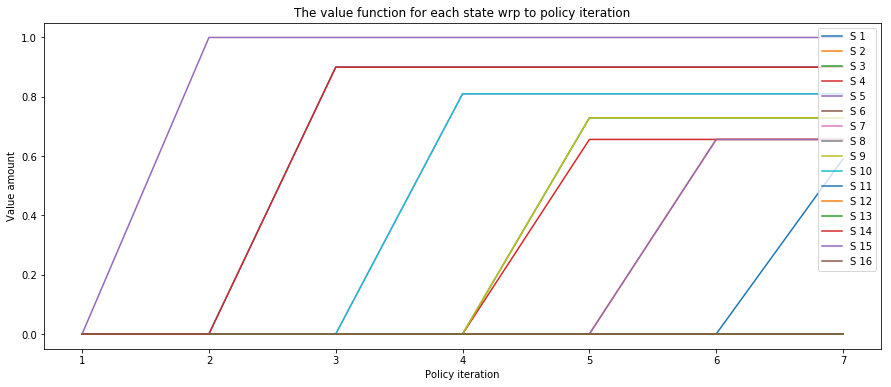

In [42]:
### (b)
import matplotlib.pyplot as plt
valueset = []
for i in range(1,8):
    new_policy, value_function, num_pol_iter, num_val_iter = policy_iteration_sync(env,0.9, i, tol=1e-3)
    valueset.append(value_function)
valueset = np.array(valueset).T
a = np.linspace(1,7,num=7)
plt.figure(figsize=(15,6))
for i in range(16):
    plt.plot(a,valueset[i],label = 'S ' + str(i+1))
    plt.legend(loc=1, prop={'size': 10})
plt.xlabel('Policy iteration')   
plt.ylabel('Value amount')
plt.title('The value function for each state wrp to policy iteration 4x4')


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


Text(0.5,1,'The value function for each state wrp to policy iteration 8x8')

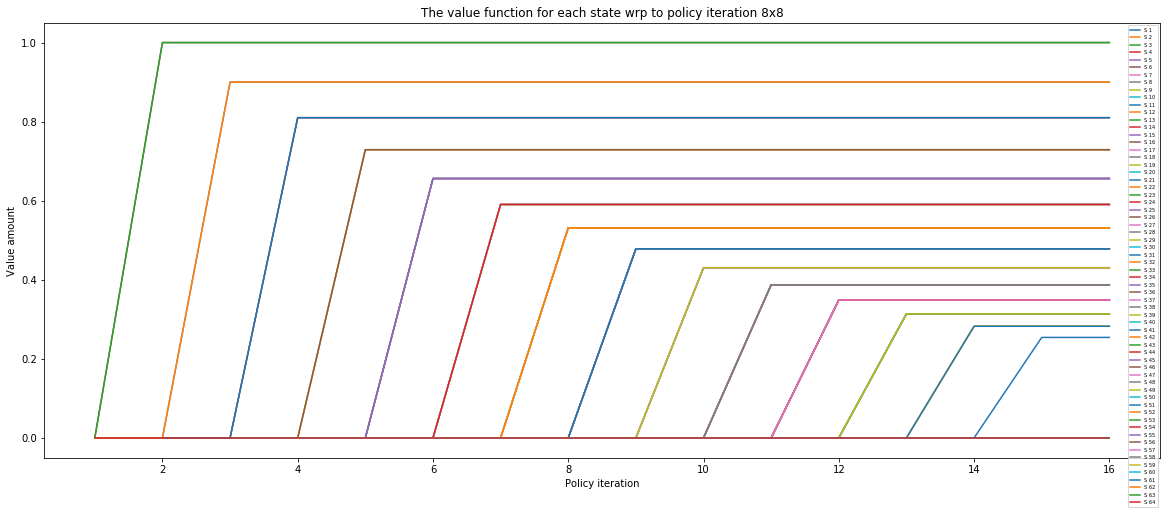

In [46]:
env = FrozenLakeEnv(map_name ="8x8", is_slippery=False)
env.render()
valueset = []
for i in range(1,17):
    new_policy, value_function, num_pol_iter, num_val_iter = policy_iteration_sync(env,0.9, i, tol=1e-3)
    valueset.append(value_function)
valueset = np.array(valueset).T
a = np.linspace(1,16,num=16)
plt.figure(figsize=(20,8))
for i in range(64):
    plt.plot(a,valueset[i],label = 'S ' + str(i+1))
    plt.legend(loc=1, prop={'size': 5})
plt.xlabel('Policy iteration')   
plt.ylabel('Value amount')
plt.title('The value function for each state wrp to policy iteration 8x8')

### My observations are that after one by one some states remain fixed values, which means that they no longer change. This is the state convergence under asynchronous improvement, until after the optimal iterations that lead to all value functions unchanged with optimal policy.

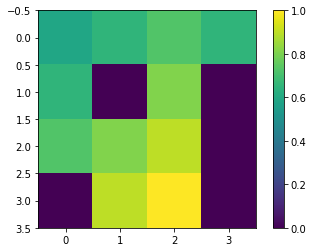

In [47]:
### (c)

import matplotlib.pyplot as plt
plt.imshow(value_func.reshape(4,4));
plt.colorbar();